In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.layers import Input, Dense
from keras.models import Model, Sequential

from sklearn.model_selection import train_test_split
from sklearn import metrics
from IPython.display import display, clear_output

In [ ]:
!nvidia-smi -L # list GPUs available

In [6]:
!export CUDA_VISIBLE_DEVICES=0

In [2]:
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]

x = {}
x_array_read = np.load("x_array.npy",allow_pickle=True)
mycounter = -1
for m1 in mass_range:
    for m2 in mass_range:
        if (m1==0 and m2>0 or m2==0 and m1>0):
            continue
        mycounter+=1
        x[m1,m2] = x_array_read[mycounter]

In [3]:
x_vals_all = np.load("x_vals_all.npy")
y_vals_all = np.load("y_vals_all.npy")

In [4]:
x_vals_all

array([[-1.08511704, -0.13951411,  0.29623825, -1.38625319,  0.5       ,
         0.5       ],
       [-0.99621376, -0.3906208 ,  1.87209617, -1.20087092,  0.5       ,
         0.5       ],
       [-1.10503705,  1.30397829,  1.37879233, -0.51460752,  0.5       ,
         0.5       ],
       ...,
       [ 2.25225265, -1.04538567, -1.74062478, -0.42062581,  6.        ,
         6.        ],
       [ 1.9191695 , -0.87384445, -1.59395235, -2.25172332,  6.        ,
         6.        ],
       [ 0.04826932,  1.34560735, -0.34342313, -1.79483175,  6.        ,
         6.        ]])

In [5]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [6]:
#model_all_BCE = tf.keras.models.load_model("model_all_BCE_3_4096")
model_all_MSE = tf.keras.models.load_model("model_all_MSE_3_4096")

2023-10-31 00:18:07.738399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 00:18:08.965034: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 34429 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [7]:
def createSimpleModel(weight):
    input_layer = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation="relu",
                         kernel_initializer=tf.keras.initializers.Constant(weight))(input_layer)
    model = Model(inputs=input_layer, outputs=simple_model)
    return model

4 Features 2 Parameter Semi Weakly Supervised Model

In [8]:
sig_list = []
w1_list = []
w2_list = []
w3_list = []

max_SIC1 = []
max_SIC2 = []

fit_out = {}

epsilon = 1e-6

sig_space = np.logspace(-3, -1, 20)
#for sigfrac in sig_space:
sigfrac = .05
print("Signal Fraction: ", sigfrac)
for l in model_all_MSE.layers:
    l.trainable=False

model3 = createSimpleModel(.5)
model32 = createSimpleModel(.5)

inputs_hold3 = tf.keras.Input(shape=(1,))
simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

inputs = tf.keras.Input(shape=(4,))
inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
hidden_layer_1 = model_all_MSE(inputs2)
LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
LLR_xs = 1 + sigfrac * LLR - sigfrac
#LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR - model33(tf.ones_like(inputs)[:,0])
ws = (LLR_xs / (1.+ LLR_xs))
model_all2 = Model(inputs = inputs, outputs = ws)
model_all2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

m1 = 3
m2 = 3

test_background = int(1/2 *len(x[0,0]))
train_background = int(1/4 * len(x[0,0]))
train_data = int(1/4 * len(x[0,0]))
train_reference = int(1/4 * len(x[0,0]))
#signal
test_signal_length = int(1/2*len(x[m1,m2]))
N = int(1/4 * (len(x[0,0])))
signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

x_vals_ = np.concatenate([x[0,0][test_background:],signal])
#[reference (1), data_background (0), signal(0)]
y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])
print(train_reference,len(x[0,0])-train_reference,len(x[m1,m2][0:int(sigfrac*train_reference)]),len(x[m1,m2][0:int(sigfrac*train_reference)])/train_reference)

X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

with tf.device('/GPU:0'):
    for epoch in range(20):
        myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=1,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, callbacks = [es])
        w1_out = model_all2.trainable_weights[0].numpy()[0][0]
        w2_out = model_all2.trainable_weights[1].numpy()[0][0]
        fit_out[epoch] = [w1_out, w2_out]

sig_list+=[sigfrac]
w1_list+=[model_all2.trainable_weights[0].numpy()[0][0]]
w2_list+=[model_all2.trainable_weights[1].numpy()[0][0]]
#w3_list+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]

print(m1, m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])

scores = model_all2.predict(np.concatenate([x[0,0][0:train_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
y = np.concatenate([np.zeros(train_background),np.ones(test_signal_length)])
fpr, tpr, _ = metrics.roc_curve(y, scores)
    
    #CWOLA
#     model_cwola = Sequential()
#     model_cwola.add(Dense(128, input_dim=4, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(1, activation='sigmoid'))
#     model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
    
#     scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
#     y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
#     fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
#     plt.plot(tpr,tpr/np.sqrt(fpr + epsilon))
#     plt.plot(tpr2,tpr2/np.sqrt(fpr2 + epsilon))
    
#     max_SIC1+=[np.max(tpr/np.sqrt(fpr+epsilon))]
#     max_SIC2+=[np.max(tpr2/np.sqrt(fpr2+epsilon))]

Signal Fraction:  0.05
30232 90698 1511 0.049980153479756546
18/31 [================>.............] - ETA: 0s - loss: 0.2503 

2023-10-31 00:18:18.865865: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


31/31 [==============================] - 0s 7ms/step - loss: 0.2464 - val_loss: 0.2465
3 3 1.0927403 1.5522531
66/66 [==============================] - 0s 1ms/step


In [9]:
m1_list = np.unique(x_vals_all[:, -2])
m2_list = np.unique(x_vals_all[:, -1])

In [10]:
m1_list

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ])

In [349]:
count = 0
test = {}
test_list = []
for m1 in m1_list:
    for m2 in m2_list:
        for w1 in m1_list:
            for w2 in m2_list:
                print(w1, w2, m1, m2)
                count+=1
                test_list.append(count)
                
                if count == (len(m1_list) * len(m2_list)):
                    test[m1,m2] = test_list
                    count = 0
                    test_list = []

0.5 0.5 0.5 0.5
0.5 1.0 0.5 0.5
0.5 1.5 0.5 0.5
0.5 2.0 0.5 0.5
0.5 2.5 0.5 0.5
0.5 3.0 0.5 0.5
0.5 3.5 0.5 0.5
0.5 4.0 0.5 0.5
0.5 4.5 0.5 0.5
0.5 5.0 0.5 0.5
0.5 5.5 0.5 0.5
0.5 6.0 0.5 0.5
1.0 0.5 0.5 0.5
1.0 1.0 0.5 0.5
1.0 1.5 0.5 0.5
1.0 2.0 0.5 0.5
1.0 2.5 0.5 0.5
1.0 3.0 0.5 0.5
1.0 3.5 0.5 0.5
1.0 4.0 0.5 0.5
1.0 4.5 0.5 0.5
1.0 5.0 0.5 0.5
1.0 5.5 0.5 0.5
1.0 6.0 0.5 0.5
1.5 0.5 0.5 0.5
1.5 1.0 0.5 0.5
1.5 1.5 0.5 0.5
1.5 2.0 0.5 0.5
1.5 2.5 0.5 0.5
1.5 3.0 0.5 0.5
1.5 3.5 0.5 0.5
1.5 4.0 0.5 0.5
1.5 4.5 0.5 0.5
1.5 5.0 0.5 0.5
1.5 5.5 0.5 0.5
1.5 6.0 0.5 0.5
2.0 0.5 0.5 0.5
2.0 1.0 0.5 0.5
2.0 1.5 0.5 0.5
2.0 2.0 0.5 0.5
2.0 2.5 0.5 0.5
2.0 3.0 0.5 0.5
2.0 3.5 0.5 0.5
2.0 4.0 0.5 0.5
2.0 4.5 0.5 0.5
2.0 5.0 0.5 0.5
2.0 5.5 0.5 0.5
2.0 6.0 0.5 0.5
2.5 0.5 0.5 0.5
2.5 1.0 0.5 0.5
2.5 1.5 0.5 0.5
2.5 2.0 0.5 0.5
2.5 2.5 0.5 0.5
2.5 3.0 0.5 0.5
2.5 3.5 0.5 0.5
2.5 4.0 0.5 0.5
2.5 4.5 0.5 0.5
2.5 5.0 0.5 0.5
2.5 5.5 0.5 0.5
2.5 6.0 0.5 0.5
3.0 0.5 0.5 0.5
3.0 1.0 0.5 0.5
3.0 1.5 

In [ ]:
z = {}
z_allm1m2 = np.load("z_allm1m2.npy", allow_pickle=True).item()
losses = []

epsilon = 1e-6
sigfrac = 0.05
print("Signal Fraction: ", sigfrac)
for m1 in m1_list:
    if (sigfrac,m1,m2) not in z_allm1m2 and (m1 = 0.5 and m2 = 0.5):
        print(w1, w2, m1, m2)
    for m2 in m2_list:
        for w1 in m1_list:
            for w2 in m2_list:
                
                for l in model_all_MSE.layers:
                    l.trainable=False

                model3 = createSimpleModel(w1)
                model32 = createSimpleModel(w2)

                inputs_hold3 = tf.keras.Input(shape=(1,))
                simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
                model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

                inputs = tf.keras.Input(shape=(4,))
                inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
                hidden_layer_1 = model_all_MSE(inputs2)
                LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
                LLR_xs = 1 + sigfrac*LLR - sigfrac
                #LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR
                ws = LLR_xs / (1.+ LLR_xs)
                model_all2 = Model(inputs = inputs, outputs = ws)
                model_all2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

                m1 = m1
                m2 = m2

                if (sigfrac,m1,m2) in z_allm1m2:
                    break

                test_background = int(1/2 *len(x[0,0]))
                train_background = int(1/4 * len(x[0,0]))
                train_data = int(1/4 * len(x[0,0]))
                train_reference = int(1/4 * len(x[0,0]))
                #signal
                test_signal_length = int(1/2*len(x[m1,m2]))
                N = int(1/4 * (len(x[0,0])))
                signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

                x_vals_ = np.concatenate([x[0,0][test_background:],signal])
                #[reference (0), data_background (1), signal(1)]
                y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])
                
                X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

                # for epoch in range(20):
                #     myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=20,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, callbacks = [es])
                #     w1_out = model_all2.trainable_weights[0].numpy()[0][0]
                #     w2_out = model_all2.trainable_weights[1].numpy()[0][0]
                #     fit_out[epoch] = [w1_out, w2_out]
                
                with tf.device('/GPU:0'):
                    loss = model_all2.evaluate(x_vals_, y_vals_, verbose = 0)
                z[w1, w2] = loss
                losses.append(loss)

        if (sigfrac,m1,m2) in z_allm1m2:
            print("Landscape for m1 = {} ".format(m1) + "and " + "m2 = {} ".format(m2) +" already exists for " + "{}".format(sigfrac) + " signal fraction")
        else:
            z_allm1m2[sigfrac,m1,m2] = losses
            np.save("z_allm1m2", z_allm1m2)

In [27]:
z_allm1m2.keys()

dict_keys([(0.05, 0.5, 0.5), (0.05, 3, 4.5), (0.05, 0.5, 1.0), (0.05, 0.5, 1.5), (0.05, 0.5, 2.0), (0.05, 0.5, 2.5), (0.05, 0.5, 3.0), (0.05, 0.5, 3.5), (0.05, 0.5, 4.0), (0.05, 0.5, 4.5), (0.05, 0.5, 5.0), (0.05, 0.5, 5.5), (0.05, 0.5, 6.0), (0.05, 1.0, 0.5), (0.05, 1.0, 1.0), (0.05, 1.0, 1.5), (0.05, 1.0, 2.0), (0.05, 1.0, 2.5), (0.05, 1.0, 3.0), (0.05, 1.0, 3.5), (0.05, 1.0, 4.0), (0.05, 1.0, 4.5), (0.05, 1.0, 5.0), (0.05, 1.0, 5.5), (0.05, 1.0, 6.0), (0.05, 1.5, 0.5), (0.05, 1.5, 1.0), (0.05, 1.5, 1.5), (0.05, 1.5, 2.0), (0.05, 1.5, 2.5), (0.05, 1.5, 3.0), (0.05, 1.5, 3.5), (0.05, 1.5, 4.0), (0.05, 1.5, 4.5), (0.05, 1.5, 5.0), (0.05, 1.5, 5.5), (0.05, 1.5, 6.0), (0.05, 2.0, 0.5), (0.05, 2.0, 1.0), (0.05, 2.0, 1.5), (0.05, 2.0, 2.0), (0.05, 2.0, 2.5)])

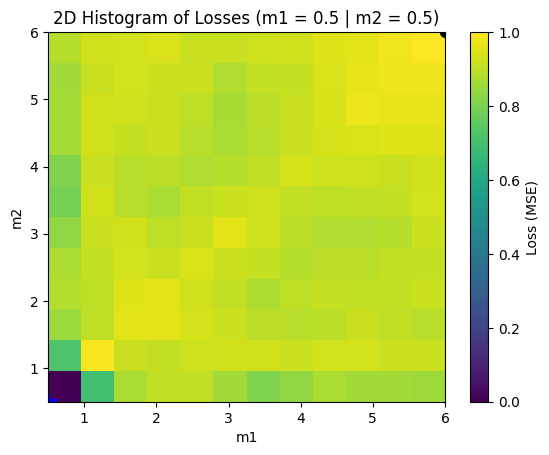

In [24]:
def loss_landscape_2D(m1, m2, w1_out, w2_out):
    m1_values, m2_values = zip(*z.keys())

    loss_values = list(z.values())
    min_loss = min(loss_values)
    max_loss = max(loss_values)

    star1_coords = (m1, m2)  
    star2_coords = (m2, m1)
    fitoutput_coords = (w1_out, w2_out)

    normalized_loss = [(x - min_loss) / (max_loss - min_loss) for x in loss_values]
    
    h = plt.hist2d(m1_values, m2_values, bins=(12, 12), cmap='viridis', weights=normalized_loss)
    plt.scatter(*star1_coords, c='red', marker='*', s=200, label='Star 1')
    plt.scatter(*star2_coords, c='blue', marker='*', s=200, label='Star 2')
    plt.scatter(*fitoutput_coords, c='black', marker='.', s=200, label='fit_output')
    plt.colorbar(label='Loss (MSE)')

    plt.xlabel('m1')
    plt.ylabel('m2')
    plt.title('2D Histogram of Losses (m1 = {}'.format(m1) + " | m2 = {})".format(m2))
    return h

loss_landscape_2D(m1, m2, w1, w2);

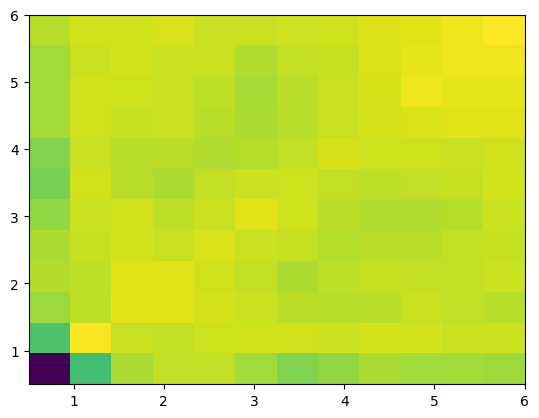

In [280]:
m1_values, m2_values = zip(*z.keys())

#loss_values = list(z_all.values())

plt.hist2d(m1_values, m2_values, bins=(12, 12), cmap='viridis', weights=loss_values);

In [212]:
test_losses = []
count = 0
for m1 in mass_range[1:]:
    for m2 in mass_range[1:]:
        print(m1,m2)
        count+=1
        test_losses.append(z[m1,m2])

0.5 0.5
0.5 1
0.5 1.5
0.5 2
0.5 2.5
0.5 3
0.5 3.5
0.5 4
0.5 4.5
0.5 5
0.5 5.5
0.5 6
1 0.5
1 1
1 1.5
1 2
1 2.5
1 3
1 3.5
1 4
1 4.5
1 5
1 5.5
1 6
1.5 0.5
1.5 1
1.5 1.5
1.5 2
1.5 2.5
1.5 3
1.5 3.5
1.5 4
1.5 4.5
1.5 5
1.5 5.5
1.5 6
2 0.5
2 1
2 1.5
2 2
2 2.5
2 3
2 3.5
2 4
2 4.5
2 5
2 5.5
2 6
2.5 0.5
2.5 1
2.5 1.5
2.5 2
2.5 2.5
2.5 3
2.5 3.5
2.5 4
2.5 4.5
2.5 5
2.5 5.5
2.5 6
3 0.5
3 1
3 1.5
3 2
3 2.5
3 3
3 3.5
3 4
3 4.5
3 5
3 5.5
3 6
3.5 0.5
3.5 1
3.5 1.5
3.5 2
3.5 2.5
3.5 3
3.5 3.5
3.5 4
3.5 4.5
3.5 5
3.5 5.5
3.5 6
4 0.5
4 1
4 1.5
4 2
4 2.5
4 3
4 3.5
4 4
4 4.5
4 5
4 5.5
4 6
4.5 0.5
4.5 1
4.5 1.5
4.5 2
4.5 2.5
4.5 3
4.5 3.5
4.5 4
4.5 4.5
4.5 5
4.5 5.5
4.5 6
5 0.5
5 1
5 1.5
5 2
5 2.5
5 3
5 3.5
5 4
5 4.5
5 5
5 5.5
5 6
5.5 0.5
5.5 1
5.5 1.5
5.5 2
5.5 2.5
5.5 3
5.5 3.5
5.5 4
5.5 4.5
5.5 5
5.5 5.5
5.5 6
6 0.5
6 1
6 1.5
6 2
6 2.5
6 3
6 3.5
6 4
6 4.5
6 5
6 5.5
6 6


In [186]:
len(test_losses)

144

In [252]:
m_space

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ])

In [254]:
# Define the spacing for the grid
spacing_x = 0.5
spacing_y = 0.5

# Define the size of the grid
grid_width = 12  # 12 squares in the x direction
grid_height = 12  # 12 squares in the y direction

# Initialize lists for the top and bottom triangles
top_triangle = []
bottom_triangle = []

# Loop through the top-left triangular half
for i in range(grid_height):
    for j in range(i + 1):
        x = 0.5 + j * spacing_x
        y = 0.5 + i * spacing_y
        top_triangle.append(z[x, y])

# Loop through the bottom-left triangular half
for i in range(grid_height):
    for j in range(grid_width - i - 1):
        x = 0.5 + j * spacing_x
        y = 0.5 + i * spacing_y
        bottom_triangle.append(z[x, y])

# Concatenate the two lists without mixing
concatenated_list = top_triangle + bottom_triangle


In [226]:
concatenated_list = top_triangle + bottom triangle
len(concatenated_list)

144

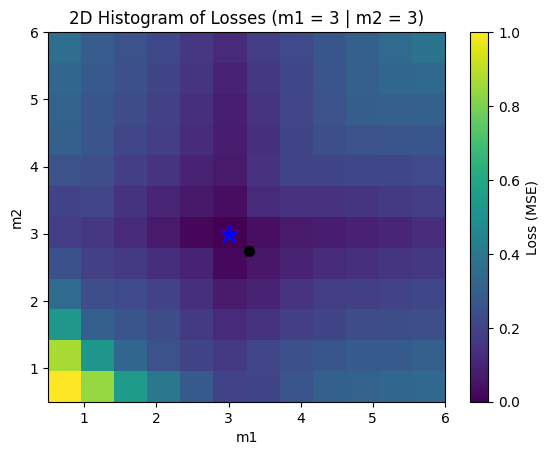

In [114]:
for key, value in fit_out.items():
    w1_fit_coord = value[0]
    w2_fit_coord = value[1]
    
    plt.figure()
    loss_landscape_2D(m1, m2, w1_fit_coord, w2_fit_coord)
    plt.show()
    clear_output(wait=True)

In [ ]:
sig_list = []
w1_list = []
w2_list = []
w3_list = []

max_SIC1 = []
max_SIC2 = []

test_list = []

epsilon = 1e-6

sig_space = np.logspace(-3, -1, 20)
for sigfrac in sig_space:
    print("Signal Fraction: ", sigfrac)
    for l in model_all_MSE.layers:
        l.trainable=False

    model3 = createSimpleModel(2)
    model32 = createSimpleModel(3)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(4,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_all_MSE(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
    LLR_xs = 1 + sigfrac * LLR - sigfrac
    #LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR - model33(tf.ones_like(inputs)[:,0])
    ws = (LLR_xs / (1.+ LLR_xs))
    model_all2 = Model(inputs = inputs, outputs = ws)
    model_all2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

    m1 = 4.5
    m2 = 6

    test_background = int(1/2 *len(x[0,0]))
    train_background = int(1/4 * len(x[0,0]))
    train_data = int(1/4 * len(x[0,0]))
    train_reference = int(1/4 * len(x[0,0]))
    #signal
    test_signal_length = int(1/2*len(x[m1,m2]))
    N = int(1/4 * (len(x[0,0])))
    signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

    x_vals_ = np.concatenate([x[0,0][test_background:],signal])
    #[reference (1), data_background (0), signal(0)]
    y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])
    print(train_reference,len(x[0,0])-train_reference,len(x[m1,m2][0:int(sigfrac*train_reference)]),len(x[m1,m2][0:int(sigfrac*train_reference)])/train_reference)

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

    myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=20,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, callbacks = [es])

    sig_list+=[sigfrac]
    w1_list+=[model_all2.trainable_weights[0].numpy()[0][0]]
    w2_list+=[model_all2.trainable_weights[1].numpy()[0][0]]
    #w3_list+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]

    print(m1, m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])

    scores = model_all2.predict(np.concatenate([x[0,0][0:train_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
    y = np.concatenate([np.zeros(train_background),np.ones(test_signal_length)])
    fpr, tpr, _ = metrics.roc_curve(y, scores)
    
    #CWOLA
#     model_cwola = Sequential()
#     model_cwola.add(Dense(128, input_dim=4, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(1, activation='sigmoid'))
#     model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
    
#     scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
#     y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
#     fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
#     plt.plot(tpr,tpr/np.sqrt(fpr + epsilon))
#     plt.plot(tpr2,tpr2/np.sqrt(fpr2 + epsilon))
    
#     max_SIC1+=[np.max(tpr/np.sqrt(fpr+epsilon))]
#     max_SIC2+=[np.max(tpr2/np.sqrt(fpr2+epsilon))]

In [ ]:
plt.plot(sig_list,np.array(w1_list)*100)
plt.plot(sig_list,np.array(w2_list)*100)
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions MSE (3 params)")
plt.axhline(m2 * 100,ls=":",color='orange')
plt.axhline(m1 * 100,ls=":",color='blue')
#plt.legend()
plt.ylim([0,700])

In [ ]:
plt.plot(sig_list,np.array(w3_list))
plt.xscale("log")
plt.yscale("log")
plt.plot(sig_list,sig_list,ls=":",color="black")
plt.xlabel("S/B")
plt.ylabel("Fitted S/B")
plt.title("S/B vs Fitted S/B")

In [ ]:
plt.plot(sig_list,max_SIC1,label="Weakly, Semisupervised")
plt.plot(sig_list,max_SIC2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly (Trainable mu)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("max SIC")